# EECS 731 Climate Changes

**Author: Likitha Vemulapalli<br>
Date: 11-23-2020 <br>
M.S in Computer Science <br>
University of Kansas**

# Classification of Temperature and Conditions in Australia

# Importing Libraries

In [1]:
#importing required libraries
import pandas as pd
import numpy as np

#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For Cross-Validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#For Classifier models
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

# Importing the data

In [2]:
df = pd.read_csv('australia.csv')
df.head()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,australia,01/01/1970,62.3,55.1,59.9,NaN,NaN,0.0,NaN,19.5,NaN,NaN,97.5,82.74,Overcast
1,australia,01/02/1970,53.9,50.3,51.9,NaN,NaN,0.0,NaN,18.3,NaN,NaN,93.8,78.11,Overcast
2,australia,01/03/1970,56.0,48.8,52.3,43.4,NaN,0.0,NaN,15.0,NaN,NaN,100.0,85.87,Overcast
3,australia,01/04/1970,64.1,51.2,56.3,NaN,NaN,0.0,NaN,16.1,NaN,NaN,91.3,83.15,Overcast
4,australia,01/05/1970,72.2,50.3,61.4,NaN,NaN,0.0,NaN,11.4,NaN,NaN,75.0,71.98,Partially cloudy


In [3]:
#dropping the columns that are not required for classification
df = df.drop(columns = ['Name', 'Date time'])

In [4]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,62.3,55.1,59.9,NaN,NaN,0.0,NaN,19.5,NaN,NaN,97.5,82.74,Overcast
1,53.9,50.3,51.9,NaN,NaN,0.0,NaN,18.3,NaN,NaN,93.8,78.11,Overcast
2,56.0,48.8,52.3,43.4,NaN,0.0,NaN,15.0,NaN,NaN,100.0,85.87,Overcast
3,64.1,51.2,56.3,NaN,NaN,0.0,NaN,16.1,NaN,NaN,91.3,83.15,Overcast
4,72.2,50.3,61.4,NaN,NaN,0.0,NaN,11.4,NaN,NaN,75.0,71.98,Partially cloudy


To remove the redundancy in the Conditions, I seperated the text based on the comma and created new column to predict the Conditions

In [5]:
df["Conditions"]= df["Conditions"].str.split(",", n = 1, expand = True) 

In [6]:
#checking for the null values
df.isnull().sum()

Maximum Temperature        0
Minimum Temperature        0
Temperature                0
Wind Chill             10058
Heat Index             15539
Precipitation              0
Snow Depth             18539
Wind Speed                 0
Wind Gust              18401
Visibility              1107
Cloud Cover                0
Relative Humidity          0
Conditions                 0
dtype: int64

Note: As we have huge number of null values in Wind Chill, Heat Index, Snow Depth, Visibility and Wind Gust we are dropping these columns

In [7]:
#removing columns with most null values
df = df.drop(columns = ['Wind Chill', 'Heat Index', 'Snow Depth', 'Wind Gust', 'Visibility'])

In [8]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Conditions
0,62.3,55.1,59.9,0.0,19.5,97.5,82.74,Overcast
1,53.9,50.3,51.9,0.0,18.3,93.8,78.11,Overcast
2,56.0,48.8,52.3,0.0,15.0,100.0,85.87,Overcast
3,64.1,51.2,56.3,0.0,16.1,91.3,83.15,Overcast
4,72.2,50.3,61.4,0.0,11.4,75.0,71.98,Partially cloudy


In [9]:
#checking for the null values
df.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
dtype: int64

In [10]:
#For classification, categorizing the temperature data into 3 categories
tg_labels = [1,2,3]
df['Australia_Temp_bins'] = pd.cut(df['Temperature'], 3, labels=tg_labels, include_lowest=True)

df_temp = df[['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 'Relative Humidity', 'Australia_Temp_bins']]

df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Australia_Temp_bins
0,62.3,55.1,59.9,0.0,19.5,97.5,82.74,2
1,53.9,50.3,51.9,0.0,18.3,93.8,78.11,2
2,56.0,48.8,52.3,0.0,15.0,100.0,85.87,2
3,64.1,51.2,56.3,0.0,16.1,91.3,83.15,2
4,72.2,50.3,61.4,0.0,11.4,75.0,71.98,2


Temperature is running value, so I splitted the temperature into three Classes - low, medium and high.

In [11]:
#low = (30.337, 51.5]
#medium = (51.5, 72.6]
#high = (72.6, 93.7]

pd.cut(df['Temperature'], 3).head()

0    (51.5, 72.6]
1    (51.5, 72.6]
2    (51.5, 72.6]
3    (51.5, 72.6]
4    (51.5, 72.6]
Name: Temperature, dtype: category
Categories (3, interval[float64]): [(30.337, 51.5] < (51.5, 72.6] < (72.6, 93.7]]

In [12]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Australia_Temp_bins
0,62.3,55.1,59.9,0.0,19.5,97.5,82.74,2
1,53.9,50.3,51.9,0.0,18.3,93.8,78.11,2
2,56.0,48.8,52.3,0.0,15.0,100.0,85.87,2
3,64.1,51.2,56.3,0.0,16.1,91.3,83.15,2
4,72.2,50.3,61.4,0.0,11.4,75.0,71.98,2


In [13]:
df_temp.shape

(18570, 8)

In [14]:
df_temp.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Cloud Cover            0
Relative Humidity      0
Australia_Temp_bins    0
dtype: int64

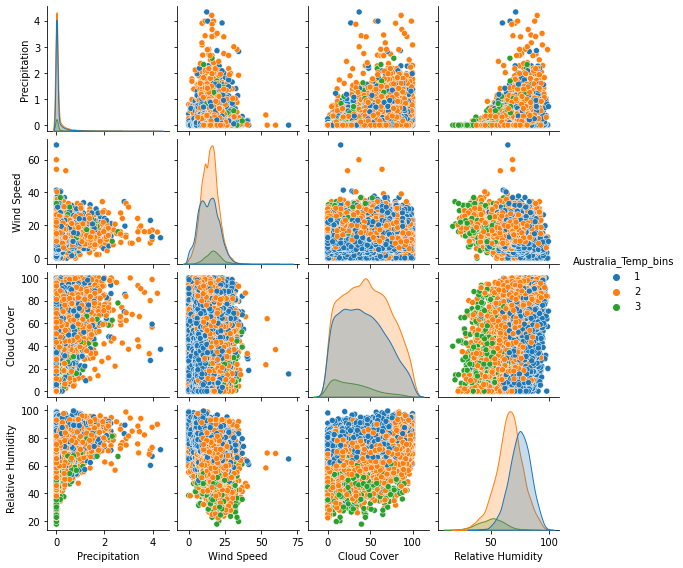

In [15]:
# Pair plot to get the distributions of temp_bins
pair_plot = sns.pairplot(df_temp, hue='Australia_Temp_bins',vars=['Precipitation', 'Wind Speed', 'Cloud Cover', 'Relative Humidity'], height=2)

Pair plots are simple way to visualize relationships between each variable.<br>
Here, we could see that precipitation has nothing much to do with temperature, we can drop  that column as it doesn't show much affect

# Classification of Temperature

In [16]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Australia_Temp_bins
0,62.3,55.1,59.9,0.0,19.5,97.5,82.74,2
1,53.9,50.3,51.9,0.0,18.3,93.8,78.11,2
2,56.0,48.8,52.3,0.0,15.0,100.0,85.87,2
3,64.1,51.2,56.3,0.0,16.1,91.3,83.15,2
4,72.2,50.3,61.4,0.0,11.4,75.0,71.98,2


In [17]:
#removing columns which are not required
df_temp = df_temp.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation'])

In [18]:
df_temp.head()

,Wind Speed,Cloud Cover,Relative Humidity,Australia_Temp_bins
0,19.5,97.5,82.74,2
1,18.3,93.8,78.11,2
2,15.0,100.0,85.87,2
3,16.1,91.3,83.15,2
4,11.4,75.0,71.98,2


For using cross validation, we divide the data into arrays specifically X having the features and y being the temperature column.

In [19]:
# Split-out dataset
array = df_temp.values
X = array[:,0:3]
print(X)
y = array[:,3]
print(y)


[[ 19.5   97.5   82.74]
 [ 18.3   93.8   78.11]
 [ 15.   100.    85.87]
 ...
 [ 21.9   81.1   71.76]
 [ 10.3   61.    71.66]
 [ 10.3   92.9   75.28]]
[2. 2. 2. ... 2. 2. 2.]


In [20]:
# 10 fold cross validation

kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [22]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 68.33


In [23]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 58.35


In [24]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 12)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 67.07


In [25]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 65.95


In [26]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 64.25


In [27]:
#Comparing models to get the best suitable model

In [28]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Linear SVC,68.33
2,KNN,67.07
3,Random Forest,65.95
4,Gaussian Naive Bayes,64.25
1,Decision Tree,58.35


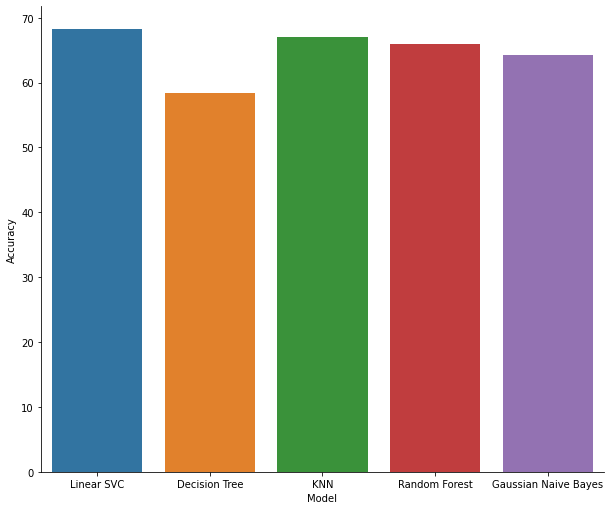

In [29]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

On comparing models, we observe that Linear SVC performed well rather than other models. There was not huge difference between  KNN and random forest too.

# Classification of Conditions

In [30]:
## Classifying conditions

In [31]:
df_conditions = df.copy(deep=True)

In [32]:
df_conditions.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Conditions,Australia_Temp_bins
0,62.3,55.1,59.9,0.0,19.5,97.5,82.74,Overcast,2
1,53.9,50.3,51.9,0.0,18.3,93.8,78.11,Overcast,2
2,56.0,48.8,52.3,0.0,15.0,100.0,85.87,Overcast,2
3,64.1,51.2,56.3,0.0,16.1,91.3,83.15,Overcast,2
4,72.2,50.3,61.4,0.0,11.4,75.0,71.98,Partially cloudy,2


In [33]:
df_conditions.shape

(18570, 9)

In [34]:
#removing columns which are not required
df_conditions = df_conditions.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'Australia_Temp_bins'])

In [35]:
df_conditions.isnull().sum()

Temperature          0
Precipitation        0
Wind Speed           0
Cloud Cover          0
Relative Humidity    0
Conditions           0
dtype: int64

In [36]:
df_conditions.describe()

,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity
count,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000
mean,55.564653,0.086150,14.245374,42.961572,68.550139
std,10.630173,0.271009,6.155212,26.457987,12.160083
min,30.400000,0.000000,0.000000,0.000000,17.710000
25%,46.900000,0.000000,9.700000,20.800000,61.280000
50%,55.200000,0.000000,14.000000,41.500000,69.400000
75%,63.800000,0.020000,18.300000,63.300000,77.080000
max,93.700000,4.330000,68.900000,100.000000,99.410000


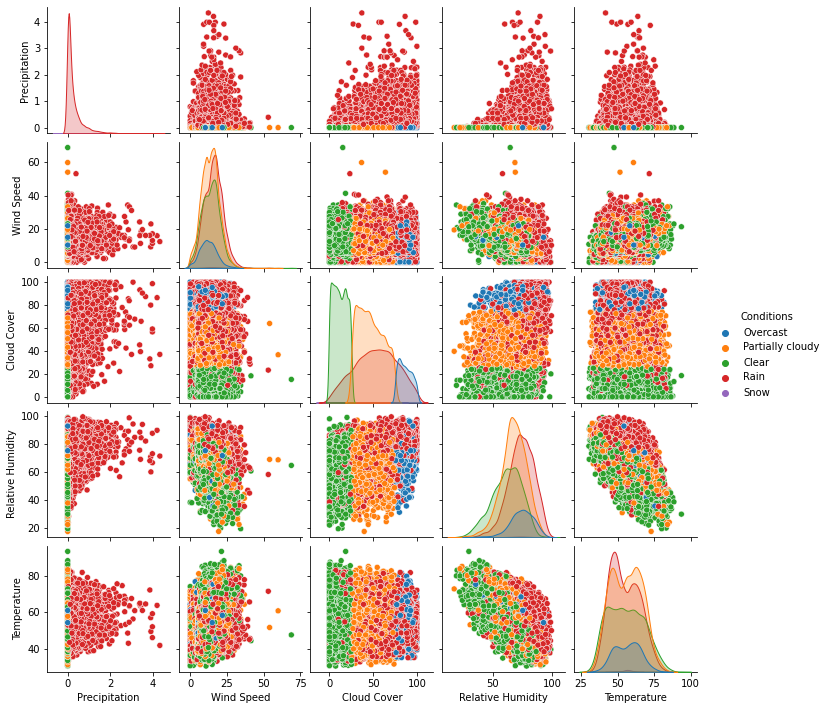

In [37]:
# Pair plot to get the distributions of Conditions
import warnings
warnings.simplefilter('ignore')
pair_plot = sns.pairplot(df_conditions, hue='Conditions',vars=['Precipitation', 'Wind Speed','Cloud Cover','Relative Humidity', 'Temperature'], height=2)

In [38]:
df_conditions.head()

,Temperature,Precipitation,Wind Speed,Cloud Cover,Relative Humidity,Conditions
0,59.9,0.0,19.5,97.5,82.74,Overcast
1,51.9,0.0,18.3,93.8,78.11,Overcast
2,52.3,0.0,15.0,100.0,85.87,Overcast
3,56.3,0.0,16.1,91.3,83.15,Overcast
4,61.4,0.0,11.4,75.0,71.98,Partially cloudy


In [39]:
# Split-out dataset
array = df_conditions.values
X = array[:,0:5]
print(X)
y = array[:,5]
print(y)


[[59.9 0.0 19.5 97.5 82.74]
 [51.9 0.0 18.3 93.8 78.11]
 [52.3 0.0 15.0 100.0 85.87]
 ...
 [58.4 0.0 21.9 81.1 71.76]
 [57.9 0.0 10.3 61.0 71.66]
 [61.1 0.0 10.3 92.9 75.28]]
['Overcast' 'Overcast' 'Overcast' ... 'Overcast' 'Partially cloudy'
 'Overcast']


In [40]:
kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [42]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 82.54


In [43]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 99.55


In [44]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 5)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 77.37


In [45]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 99.82


In [46]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 98.12


In [47]:
#Comparing models to get the best suitable model

In [48]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,Random Forest,99.82
1,Decision Tree,99.55
4,Gaussian Naive Bayes,98.12
0,Linear SVC,82.54
2,KNN,77.37


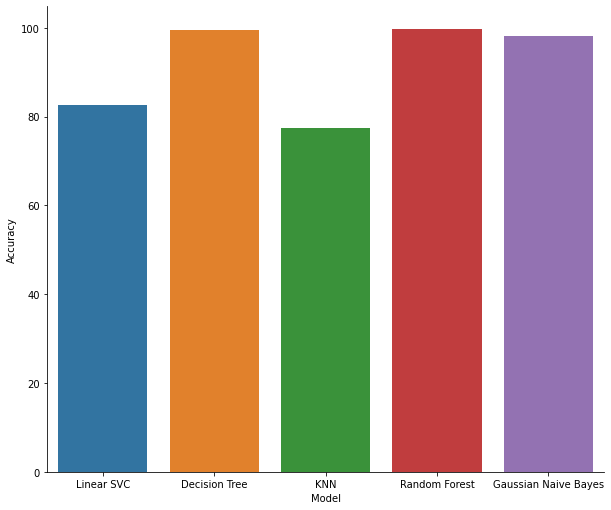

In [49]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

We can see clearly that Decision Tree and Random Forest Classifiers performed pretty good on predicting the test data accurately.